# Daten importieren

- transact_train   = Transaktionsdaten zum trainieren
- transact_class   = aktuelle Transaktionsdaten zum testen
- realclass_t1     = "Lösung" der transact_class ob Käufer oder nicht

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [55]:
import pandas as pd
import numpy as np

In [56]:

transact_train = pd.read_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/transact_train.txt', sep='|', na_values='?')
transact_class = pd.read_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/transact_class.txt', sep='|', na_values='?')
realclass_t1 = pd.read_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/realclass_t1.txt', sep='|', na_values='?')

# Klassifizierung der Testdaten an Testdaten anhängen

In [57]:
transact_class = pd.merge(transact_class, realclass_t1, on='sessionNo').rename(columns={'prediction': 'order'})

# Reduzierung der Trainingsdaten falls notwendig

In [3]:
def down_size_data(factor, df):
    print('Shape of dataframe before down sizing with factor' + str(factor) +':' + str(df.shape))
    sampleSize = int(len(df.index) * factor)
    df = df.sample(sampleSize)
    print('Shape of dataframe after down sizing with factor' + str(factor) + ':' + str(df.shape))
    return df

In [4]:
transact_train = down_size_data(0llll.01,transact_train)

Shape of dataframe before down sizing with factor0.01:(429013, 24)
Shape of dataframe after down sizing with factor0.01:(4290, 24)


# Daten des Typs 'String' in integer umwandeln

In [5]:
def mapping_values(df):
    if df['order'].dtype == 'object':
        df['order'] = df['order'].map({'y': 1, 'n': 0})
    df['onlineStatus'] = df['onlineStatus'].map({'y': 1, 'n': 0})
    df['availability'] = df['availability'].map({
        'completely orderable': 1, 'completely not orderable': 2, 'mainly orderable': 3,
        'mixed': 4, 'completely not determinable': 5, 'mainly not orderable': 6, 'mainly not determinable': 7
    })

In [6]:
mapping_values(transact_train)
mapping_values(transact_class)

# Kundennr. hat keine Relevanz

In [7]:
transact_train.drop('customerNo', axis=1, inplace=True)
transact_class.drop('customerNo', axis=1, inplace=True)

# Spalte 'sessionNo' als Index für Dataframe nutzen

In [8]:
transact_train.set_index('sessionNo', inplace=True)
transact_class.set_index('sessionNo', inplace=True)

# Neue Daten aus den vorhanden Spalten erzeugen

# Leere Spalten erzeugen zum füllen 

In [9]:
import numpy as np
def add_columns(copy):
    df = copy.copy()
    df['maxBStep'] = np.nan
    df['avgBStep'] = np.nan
    df['countTransact'] = np.nan
    df['maxAvailability'] = np.nan
    df['maxOnlineStatus'] = np.nan
    df['avgAvailability'] = np.nan
    df['minOnlineStatus'] = np.nan
    df['minAvailability'] = np.nan
    # sicherstellen das order in der letzten Spalte ist
    df = df.reindex(columns=(list([a for a in df.columns if a != 'order']) + ['order'] ))
    return df

In [10]:
transact_train = add_columns(transact_train)
transact_class = add_columns(transact_class)

# Daten erzeugen

In [11]:
def fill_columns(added_df):
    # Serie erzeugen mit allen unique Session Nummern
    unique_sessions = added_df.index.unique().sort_values()
    # Loop durch alle Session Nummern [1,2,3,4,....]
    for session in unique_sessions:
        if session % 1000 == 0:
            print(str(session))
        # Alle Zeilen mit der Session Nummer
        rows = added_df.loc[added_df.index == session]
        # Maximale Nummer Schritt in der Einkaufsabwicklung
        maxBStep = rows['bStep'].max()
        # Durchschn. Nummer Schritt in der Einkaufsabwicklung
        avgBStep = rows['bStep'].mean()
        # Anzahl der Transaktionen der Sessionnr.
        countTransact = len(rows.index)
        # Max. Zahl der Produktsverfügbarkeit
        maxAvailability = rows['availability'].max()
        # Min. Zahl der Produktsverfügbarkeit
        minAvailability = rows['availability'].min()
        # Durchschn. Zahl der Produktsverfügbarkeit
        avgAvailability = rows['availability'].mean()
        # Max. Zahl der Online Status (0 oder 1)
        maxOnlineStatus = rows['onlineStatus'].max()
        # Min. Zahl der Online Status (0 oder 1)
        minOnlineStatus = rows['onlineStatus'].min()
        added_df.loc[added_df.index == session,'maxBStep'] = maxBStep
        added_df.loc[added_df.index == session,'avgBStep'] = avgBStep
        added_df.loc[added_df.index == session,'countTransact'] = countTransact
        added_df.loc[added_df.index == session,'maxAvailability'] = maxAvailability
        added_df.loc[added_df.index == session,'minAvailability'] = minAvailability
        added_df.loc[added_df.index == session,'avgAvailability'] = avgAvailability
        added_df.loc[added_df.index == session,'maxOnlineStatus'] = maxOnlineStatus
        added_df.loc[added_df.index == session,'minOnlineStatus'] = minOnlineStatus

In [12]:
fill_columns(transact_train)
fill_columns(transact_class)

6000
14000
42000
50000
1000
2000
3000
4000
5000


## Leere Zeilen mit verschiedene Zahlen füllen
## mean = Mittelwert der jeweiligen Spalte
## median = Median der jeweiligen Spalte
## mode = Modi der einzelnen Elemente entlang der ausgewählten Achse

In [13]:
def fill_null_values(df, mode):
    if mode == 'mean':
        df = df.fillna(value=df.mean())
        print('Filled null values with mean')
    if mode == 'median':
        df = df.fillna(value=df.median())
        print('Filled null values with median')
    if mode == 'mode':
        df = df.fillna(value=df.mode().iloc[0])
        print('Filled null values with mode')
    return df

# Für Traingsdaten und Testdaten wird für die jeweiligen Modus eine eigener Dataframe erzeugt

In [14]:
train_mean = fill_null_values(transact_train, 'mean')
train_median = fill_null_values(transact_train, 'median')
train_mode = fill_null_values(transact_train, 'mode')
class_mean = fill_null_values(transact_class, 'mean')
class_median = fill_null_values(transact_class, 'median')
class_mode = fill_null_values(transact_class, 'mode')

Filled null values with mean
Filled null values with median
Filled null values with mode
Filled null values with mean
Filled null values with median
Filled null values with mode


# Wegen des langen Prozess werden die Daten in CSVs gespeichert

In [15]:
train_mean.to_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/train_mean_small.csv')
train_median.to_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/train_median_small.csv')
train_mode.to_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/train_mode_small.csv')
class_mean.to_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/class_mean_small.csv')
class_median.to_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/class_median_small.csv')
class_mode.to_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/class_mode_small.csv')

# fertig vearbeitete Daten importien

In [16]:
train_mean_small = pd.read_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/train_mean_small.csv')
class_mean_small = pd.read_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/class_mean_small.csv')

In [17]:
# set index = sessionNo was not saved to csv, have to do it again
train_mean_small.set_index('sessionNo', inplace=True)
class_mean_small.set_index('sessionNo', inplace=True)

In [18]:
train_mean_small.sort_index(inplace=True)

# make sure test and training data is same shape 

In [4]:
def get_test_data(train_df,test_df):
    X_train = train_df.iloc[:, :train_df.shape[1] - 1]
    X_test = test_df.iloc[:, :test_df.shape[1] - 1]
    y_train = train_df['order']
    y_test  = test_df['order']
    return X_train, X_test, y_train, y_test

In [6]:
def import_data_2(path):
    df = pd.read_csv(path)
    df.set_index('sessionNo', inplace=True)
    df.sort_index(inplace=True)
    return df
def get_all_data():
    columns_data = ['X_train_','X_test_','y_train_','y_test_']
    fill_modes = ['mean','mode','median']
    column_count = [5,10,15,20]
    new_dict = {}

    for fill_mode in fill_modes:
        for count in column_count:
            filename_base = '~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/'
            filename_2 = filename_base + 'train' + '_' + fill_mode + '_' + str(count) + '.csv'
            train_file = import_data_2(filename_2)
            filename_2 = filename_base + 'class' + '_' + fill_mode + '_' + str(count) + '.csv'
            class_file = import_data_2(filename_2)
            X_train, X_test, y_train, y_test = get_test_data(train_file,class_file)
            new_dict[fill_mode + '_' + str(count)] = {
                'X_train':X_train,
                'X_test':X_test,
                'y_train':y_train,
                'y_test':y_test
            }
    return new_dict

# Feature Selection with RFE and Logistic Regression

In [22]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = get_test_data(train_mean_small,class_mean_small)

In [23]:
def feature_select_rfe(X_train_rfe,y_train_rfe,iterations,attributes):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import RFE
    logistic_reg_rfe = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=iterations)
    rfe = RFE(logistic_reg_rfe, attributes)
    rfe = rfe.fit(X_train_rfe, y_train_rfe)
    # summarize the selection of the attributes
    print("Num Features: %d" % rfe.n_features_)
    print("Selected Features: %s" % rfe.support_)
    print("Feature Ranking: %s" % rfe.ranking_)
    return rfe

In [24]:
def dropBadColumns (df,rfe):
    df_copy = df.copy()
    dropArray = []
    keepArray = []
    for index in range(len(rfe.ranking_)):
        if rfe.ranking_[index] != 1:
            dropArray.append(index)
        else:
            keepArray.append(index)

    print('Columns to keep: {}'.format(list(df_copy.columns[keepArray])))
    print('Columns to discard: {}'.format(list(df_copy.columns[dropArray])))
    df_copy.drop(df_copy.columns[dropArray], axis=1,  inplace=True)
    return df_copy

## How to use these moduls

In [31]:
rfe = feature_select_rfe(X_train_rfe,y_train_rfe,1000,10)  
X_train_rfe_dropped = dropBadColumns(X_train_rfe,rfe)  
X_test_rfe_dropped  = dropBadColumns(X_test_rfe,rfe)  

/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarni

Num Features: 10
Selected Features: [False False False False False False False  True False False False False
 False  True False False False False False False False  True  True  True
  True  True  True  True  True]
Feature Ranking: [ 4  3 17  7  9 20 16  1 11 10 18  5 12  1 19 14  8 15  6  2 13  1  1  1
  1  1  1  1  1]
Columns to keep: ['bCount', 'availability', 'maxBStep', 'avgBStep', 'countTransact', 'maxAvailability', 'maxOnlineStatus', 'avgAvailability', 'minOnlineStatus', 'minAvailability']
Columns to discard: ['startHour', 'startWeekday', 'duration', 'cCount', 'cMinPrice', 'cMaxPrice', 'cSumPrice', 'bMinPrice', 'bMaxPrice', 'bSumPrice', 'bStep', 'onlineStatus', 'maxVal', 'customerScore', 'accountLifetime', 'payments', 'age', 'address', 'lastOrder']
Columns to keep: ['bCount', 'availability', 'maxBStep', 'avgBStep', 'countTransact', 'maxAvailability', 'maxOnlineStatus', 'avgAvailability', 'minOnlineStatus', 'minAvailability']
Columns to discard: ['startHour', 'startWeekday', 'dura

# prepare feature selection in advance

In [ ]:
def feature_select_rfe_feature(X_train_rfe,y_train_rfe,iterations,attributes):
    from sklearn.linear_model import LogisticRegression
    from sklearn.feature_selection import RFE
    logistic_reg_rfe = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=iterations)
    rfe = RFE(logistic_reg_rfe, attributes)
    rfe = rfe.fit(X_train_rfe, y_train_rfe)
    # summarize the selection of the attributes
    print("Num Features: %d" % rfe.n_features_)
    print("Selected Features: %s" % rfe.support_)
    print("Feature Ranking: %s" % rfe.ranking_)
    return rfe

In [ ]:
def dropBadColumns_feature (df,rfe):
    df_copy = df.copy()
    dropArray = []
    keepArray = []
    for index in range(len(rfe.ranking_)):
        if rfe.ranking_[index] != 1:
            dropArray.append(index)
        else:
            keepArray.append(index)

    print('Columns to keep: {}'.format(list(df_copy.columns[keepArray])))
    print('Columns to discard: {}'.format(list(df_copy.columns[dropArray])))
    df_copy.drop(df_copy.columns[dropArray], axis=1,  inplace=True)
    return df_copy

In [ ]:
def get_test_data_feature(train_df):
    X_train = train_df.iloc[:, :train_df.shape[1] - 1]
    y_train = train_df['order']
    return X_train, y_train

In [ ]:
train_mean = import_data('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/train_mean.csv')
train_mean_5_rfe = feature_select_rfe(X_train_mean,y_train_mean,5000,5)
train_mean_5 = dropBadColumns(train_mean,train_mean_5_rfe)
train_mean_5.to_csv('~/Google Drive/Studium/StrategischeSysteme/DMC2013/data/train_mean_5.csv')

In [ ]:
from sklearn.externals import joblib
filename = 'train_mean_5_rfe.sav'
joblib.dump(train_mean_5_rfe, filename)

# Feature Importance with Extra Trees

In [25]:
X_train_etr, X_test_etr, y_train_etr, y_test_etr = get_test_data(train_mean_small,class_mean_small)

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree_model = ExtraTreesClassifier(n_estimators=100)
extra_tree_model.fit(X_train_etr, y_train_etr)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)

In [28]:
X_train_chi, X_test_chi, y_train_chi, y_test_chi = get_test_data(train_mean_small,class_mean_small)

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

feature_sel_kbest_model = SelectKBest(score_func=chi2, k=3)
feature_sel_kbest_fit = feature_sel_kbest_model.fit(X_train_chi,  y_train_chi)
# summarize scores
print(feature_sel_kbest_fit.scores_)
features = feature_sel_kbest_fit.transform(X_train_chi)
# summarize selected features
# print(features[0:5, :])

[3.21197069e+01 5.74364339e-01 2.66399246e+04 1.44160771e+03
 3.61802442e+04 2.37000164e+04 8.85553060e+04 5.99450867e+02
 3.64564409e+04 2.11912899e+04 7.05382728e+03 3.43824189e+01
 1.14630503e-01 2.10478622e+00 2.07972852e+04 7.93352864e+01
 9.31610310e+02 2.56634152e+02 1.91034114e+00 1.73479193e-01
 2.20895970e+02 3.93466648e+01 3.71276495e+01 3.91890897e+00
 1.84073035e+00 1.25543659e-01 1.92245845e+00 1.40134301e-01
 1.90887751e+00]


# summarize all feature selection in a dataframe

In [32]:
feature_select_pd = pd.DataFrame(
    data={'Support': rfe.support_, 'Ranking': rfe.ranking_, 'Feature Importances': extra_tree_model.feature_importances_,
          'Fit Scores': feature_sel_kbest_fit.scores_}, index=list(train_mean_small.iloc[:, :train_mean_small.shape[1] - 1]))
feature_select_pd['Fit Scores'] = feature_select_pd['Fit Scores'].astype('int64')
feature_select_pd.sort_values(by=['Ranking', 'Fit Scores'])

,Support,Ranking,Feature Importances,Fit Scores
maxOnlineStatus,True,1,0.006043,0
minOnlineStatus,True,1,0.006020,0
maxAvailability,True,1,0.007661,1
avgAvailability,True,1,0.007716,1
minAvailability,True,1,0.007484,1
availability,True,1,0.007306,2
countTransact,True,1,0.017596,3
avgBStep,True,1,0.020965,37
maxBStep,True,1,0.018591,39
bCount,True,1,0.055586,599


# Visualize the results

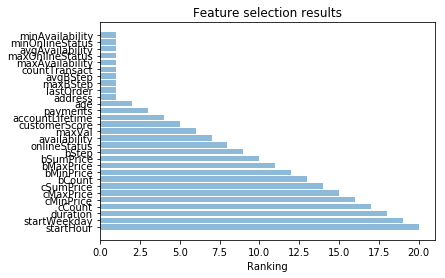

In [34]:
import matplotlib.pyplot as plt
feature_select_objects = feature_select_pd.index.values
y_pos = np.arange(len(feature_select_objects))
performance = feature_select_pd['Ranking'].sort_values(ascending=False)

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, feature_select_objects)
plt.xlabel('Ranking')
plt.title('Feature selection results')

plt.show()

# INSERT HERE COLUMN SELECTION FOR MODEL TRAINING AND PREDICTING

# K nearest neighbor

In [250]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = get_test_data(train_mean_small,class_mean_small)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler_knn = StandardScaler()
scaler.fit(X_train_knn)

/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [37]:
scaled_features_knn = scaler_knn.transform(X_train_knn)

/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [38]:
X_train_knn_feat = pd.DataFrame(scaled_features_knn,columns=X_train_knn.columns)
X_train_knn_feat.head()

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,...,address,lastOrder,maxBStep,avgBStep,countTransact,maxAvailability,maxOnlineStatus,avgAvailability,minOnlineStatus,minAvailability
0,-1.904625,-1.185052,-0.578670,-0.594483,-0.197264,-0.429769,-0.395658,-0.488625,-0.242715,-0.382288,...,-2.028271e+00,-4.747563e-01,-4.387137e-16,0.000000,-0.368511,0.000000,0.000000,0.000000,1.187741e-15,5.412535e-16
1,-1.904625,-1.185052,0.017922,0.093238,-0.302832,-0.277605,0.084401,-0.488625,-0.336864,-0.199352,...,-6.204054e-16,1.459013e-16,-3.279653e-01,-0.285869,-0.368511,-0.245812,0.135518,-0.238812,1.455540e-01,-2.233789e-01
2,-1.904625,-1.185052,-0.233970,-0.627231,-0.302772,-0.456849,-0.409212,-0.719332,-0.284097,-0.417186,...,-6.204054e-16,1.459013e-16,-4.387137e-16,0.000000,-0.368511,0.000000,0.000000,0.000000,1.187741e-15,5.412535e-16
3,-1.904625,-1.185052,-0.331706,0.027741,-0.214169,-0.250043,-0.176583,-0.257918,-0.257792,-0.328319,...,7.657862e-01,4.176145e+00,-4.387137e-16,0.000000,-0.368511,0.000000,0.000000,0.000000,1.187741e-15,5.412535e-16
4,-1.904625,-1.185052,-0.642856,-0.725477,-0.320564,-0.501729,-0.431934,-0.719332,-0.352678,-0.475023,...,7.657862e-01,-7.622292e-01,-4.387137e-16,0.000000,-0.368511,0.000000,0.000000,0.000000,1.187741e-15,5.412535e-16


In [39]:
data_log_knn = get_all_data()

In [61]:
data_log_knn['median_20']['y_test']

sessionNo
1       1
1       1
1       1
1       1
1       1
1       1
1       1
1       1
1       1
2       1
2       1
2       1
2       1
2       1
2       1
2       1
2       1
2       1
2       1
2       1
3       1
3       1
3       1
3       1
3       1
3       1
3       1
3       1
3       1
3       1
       ..
5108    0
5108    0
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5109    1
5110    0
5110    0
5110    0
5110    0
5110    0
5110    0
5111    0
5111    0
5111    0
5111    0
5111    0
5111    0
5111    0
Name: order, Length: 45068, dtype: int64

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn_model_median_20 = KNeighborsClassifier(n_neighbors=23)
knn_model_median_20.fit(data_log_knn['median_20']['X_train'], data_log_knn['median_20']['y_train'])
prediction_knn_median_20 = knn_model_median_20.predict(data_log_knn['median_20']['X_train'])
performance_knn_median_20 = value[0].score(data_log_knn['median_20']['X_test'], data_log_knn['median_20']['y_test'])*100

KeyError: 0

In [44]:
performance_knn_median_20 = knn_model_median_20.score(data_log_knn['median_20']['X_test'], data_log_knn['median_20']['y_test'])*100

In [45]:
performance_knn_median_20

72.40170409159492

In [53]:
data_log_knn['median_20']['X_test']

,startHour,startWeekday,cCount,bCount,bMaxPrice,bStep,onlineStatus,availability,payments,age,address,lastOrder,maxBStep,avgBStep,countTransact,maxAvailability,maxOnlineStatus,avgAvailability,minOnlineStatus,minAvailability
sessionNo,,,,,,,,,,,,,,,,,,,,
1,18,7,3,1,39.99,2.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,3,1,39.99,2.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,6,2,39.99,2.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,8,3,39.99,2.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,10,4,39.99,2.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,10,4,39.99,1.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,11,5,39.99,2.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,11,5,39.99,1.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0
1,18,7,11,5,39.99,2.0,1.0,1.0,5.0,49.0,1.0,65.0,2.0,1.333333,9.0,1.0,1.0,1.0,1.0,1.0


In [49]:
predict_proba_knn_median_20 = knn_model_median_20.predict_proba(data_log_knn['median_20']['X_test'])
predict_proba_knn_median_20

array([[0.17391304, 0.82608696],
       [0.17391304, 0.82608696],
       [0.52173913, 0.47826087],
       ...,
       [0.95652174, 0.04347826],
       [0.95652174, 0.04347826],
       [0.95652174, 0.04347826]])

In [40]:
from sklearn.neighbors import KNeighborsClassifier
models_knn = {}
for key, value in data_log_knn.items():
    knn_model = KNeighborsClassifier(n_neighbors=23)
    knn_model.fit(value['X_train'], value['y_train'])
    prediction_knn = knn_model.predict(value['X_test'])
    models_knn[key] = [knn_model,prediction_knn]
#     logistic_model.fit(X_train_lreg, y_train_lreg)
#     predictions_logmodel = logistic_model.predict(X_test_lreg)

KeyboardInterrupt: 

In [256]:
index_data_knn = []
column_data_knn = []
for key, value in models_knn.items():
    index_data_knn.append(key)
    column_data_knn.append(value[0].score(data_log_knn[key]['X_test'], data_log_knn[key]['y_test'])*100)
#     print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logistic_model.score(X_test_lreg, y_test_lreg)))
#     print(classification_report(y_test_lreg,predictions_logmodel))

In [257]:
df_data_knn = pd.DataFrame(index=index_data_knn, data=column_data_knn)

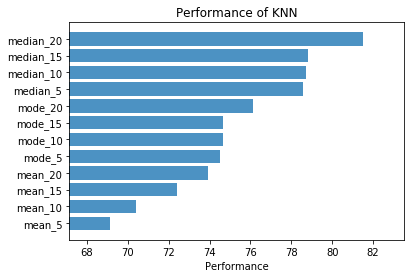

In [262]:
objects = df_data_knn.index.values
y_pos = np.arange(len(objects))
performance = df_data_knn.iloc[:,0].sort_values(ascending=True)

plt.barh(y_pos, performance, align='center', alpha=0.8,left=0)
# plt.xticks(np.arange(70, 100, step=2))
plt.xlim(performance.min()-2, performance.max()+2)
plt.yticks(y_pos, objects)
plt.xlabel('Performance')
plt.title('Performance of KNN')

plt.show()

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=23)

In [40]:
knn.fit(X_train_knn,y_train_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=23, p=2,
           weights='uniform')

In [41]:
prediction_knn = knn.predict(X_test_knn)

In [42]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test_knn,prediction_knn))
print(classification_report(y_test_knn,prediction_knn))

[[ 1640 12754]
 [ 1448 29226]]
              precision    recall  f1-score   support

           0       0.53      0.11      0.19     14394
           1       0.70      0.95      0.80     30674

   micro avg       0.68      0.68      0.68     45068
   macro avg       0.61      0.53      0.50     45068
weighted avg       0.64      0.68      0.61     45068



## Iterating over couple of n_neighbors to test error rate

In [43]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn_loop = KNeighborsClassifier(n_neighbors=i)
    knn_loop.fit(X_train_knn,y_train_knn)
    prediciton_knn_i = knn_loop.predict(X_test_knn)
    error_rate.append(np.mean(prediciton_knn_i != y_test_knn))
    print(i, flush=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Text(0, 0.5, 'Error Rate')

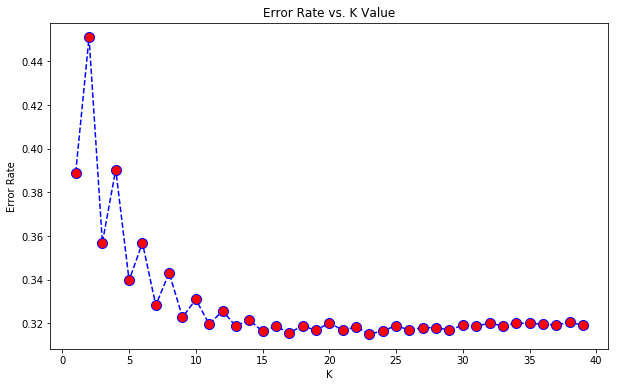

In [44]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# Logisitc Regression

In [223]:
data_log_reg = get_all_data()

In [242]:
from sklearn.linear_model import LogisticRegression
models_log_reg = {}
for key, value in data_dict.items():
    logistic_model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
    logistic_model.fit(value['X_train'], value['y_train'])
    predictions_logmodel = logistic_model.predict(value['X_test'])
    models_log_reg[key] = [logistic_model,predictions_logmodel]
#     logistic_model.fit(X_train_lreg, y_train_lreg)
#     predictions_logmodel = logistic_model.predict(X_test_lreg)

/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [246]:
index_data_log_reg = []
column_data_log_reg = []
for key, value in models_log_reg.items():
    index_data_log_reg.append(key)
    column_data_log_reg.append(value[0].score(data_log_reg[key]['X_test'], data_log_reg[key]['y_test'])*100)
#     print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logistic_model.score(X_test_lreg, y_test_lreg)))
#     print(classification_report(y_test_lreg,predictions_logmodel))

In [247]:
df_data_log_reg = pd.DataFrame(index=index_data_log_reg, data=column_data_log_reg)
from sklearn import metrics
# for idx, model_gnb in enumerate(models_gnb):
for key, value in models_log_reg.items():
    print(f'Type of feature selection: {key}')
    print(metrics.classification_report(data_dict[key]['y_test'],value[1]))
    print(metrics.confusion_matrix(data_dict[key]['y_test'], value[1]))
# print(metrics.classification_report(y_test_nab, prediction_gnb))
# print(metrics.confusion_matrix(y_test_nab, prediction_gnb))

Type of feature selection: mean_5
              precision    recall  f1-score   support

           0       0.56      0.49      0.52     14394
           1       0.77      0.82      0.79     30674

   micro avg       0.71      0.71      0.71     45068
   macro avg       0.66      0.65      0.66     45068
weighted avg       0.70      0.71      0.71     45068

[[ 7062  7332]
 [ 5654 25020]]
Type of feature selection: mean_10
              precision    recall  f1-score   support

           0       0.63      0.50      0.56     14394
           1       0.79      0.86      0.82     30674

   micro avg       0.75      0.75      0.75     45068
   macro avg       0.71      0.68      0.69     45068
weighted avg       0.74      0.75      0.74     45068

[[ 7195  7199]
 [ 4164 26510]]
Type of feature selection: mean_15
              precision    recall  f1-score   support

           0       0.65      0.48      0.55     14394
           1       0.78      0.88      0.83     30674

   micro avg    

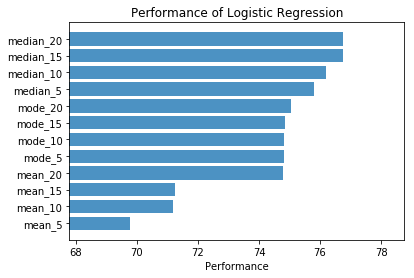

In [261]:
objects = df_data_log_reg.index.values
y_pos = np.arange(len(objects))
performance = df_data_log_reg.iloc[:,0].sort_values(ascending=True)

plt.barh(y_pos, performance, align='center', alpha=0.8,left=0)
# plt.xticks(np.arange(70, 100, step=2))
plt.xlim(performance.min()-2, performance.max()+2)
plt.yticks(y_pos, objects)
plt.xlabel('Performance')
plt.title('Performance of Logistic Regression')

plt.show()

# Naive Bayes

import data

In [167]:
data_dict = get_all_data()

In [174]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
models_gnb = {}
for key, value in data_dict.items():
    model_gnb = GaussianNB()
    model_gnb.fit(
        value['X_train'],
        value['y_train']
    )
    prediction_gnb = model_gnb.predict(value['X_test'])
    models_gnb[key] = [model_gnb,prediction_gnb]
#     models_gnb.append([model_gnb,prediction_gnb])
# model_gnb = GaussianNB()
# model_gnb.fit(
#     X_train_nab,
#     y_train_nab
# )
# prediction_gnb = model_gnb.predict(X_test_nab)

In [184]:
index_data_df = []
column_data_df = []
for key, value in models_gnb.items():
    print(f'Type of feature selection: {key}')
    print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
          .format(
              data_dict[str(key)]['X_test'].shape[0],
              (data_dict[key]['y_test'] != value[1]).sum(),
              100*(1-(data_dict[key]['y_test'] != value[1]).sum()/data_dict[key]['y_test'].shape[0])
    ))
    index_data_df.append(key)
    column_data_df.append(100*(1-(data_dict[key]['y_test'] != value[1]).sum()/data_dict[key]['y_test'].shape[0]))
    
#     print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
#       .format(
#           X_test_nab.shape[0],
#           (y_test_nab != prediction_gnb).sum(),
#           100*(1-(y_test_nab != prediction_gnb).sum()/y_test_nab.shape[0])
# ))

Type of feature selection: mean_5
Number of mislabeled points out of a total 45068 points : 11981, performance 73.42%
Type of feature selection: mean_10
Number of mislabeled points out of a total 45068 points : 12621, performance 72.00%
Type of feature selection: mean_15
Number of mislabeled points out of a total 45068 points : 12647, performance 71.94%
Type of feature selection: mean_20
Number of mislabeled points out of a total 45068 points : 12054, performance 73.25%
Type of feature selection: mode_5
Number of mislabeled points out of a total 45068 points : 11981, performance 73.42%
Type of feature selection: mode_10
Number of mislabeled points out of a total 45068 points : 12560, performance 72.13%
Type of feature selection: mode_15
Number of mislabeled points out of a total 45068 points : 12680, performance 71.86%
Type of feature selection: mode_20
Number of mislabeled points out of a total 45068 points : 12129, performance 73.09%
Type of feature selection: median_5
Number of misl

In [190]:
df_data_naive_b = pd.DataFrame(index=index_data_df, data=column_data_df)
df_data_naive_b.iloc[:,0]

mean_5       73.415727
mean_10      71.995651
mean_15      71.937960
mean_20      73.253750
mode_5       73.415727
mode_10      72.131002
mode_15      71.864738
mode_20      73.087335
median_5     73.415727
median_10    71.942398
median_15    71.909115
median_20    73.264844
Name: 0, dtype: float64

In [183]:
from sklearn import metrics
# for idx, model_gnb in enumerate(models_gnb):
for key, value in models_gnb.items():
    print(f'Type of feature selection: {key}')
    print(metrics.classification_report(data_dict[key]['y_test'],value[1]))
    print(metrics.confusion_matrix(data_dict[key]['y_test'], value[1]))
# print(metrics.classification_report(y_test_nab, prediction_gnb))
# print(metrics.confusion_matrix(y_test_nab, prediction_gnb))

Type of feature selection: mean_5
              precision    recall  f1-score   support

           0       0.79      0.23      0.36     14394
           1       0.73      0.97      0.83     30674

   micro avg       0.73      0.73      0.73     45068
   macro avg       0.76      0.60      0.59     45068
weighted avg       0.75      0.73      0.68     45068

[[ 3318 11076]
 [  905 29769]]
Type of feature selection: mean_10
              precision    recall  f1-score   support

           0       0.74      0.19      0.30     14394
           1       0.72      0.97      0.82     30674

   micro avg       0.72      0.72      0.72     45068
   macro avg       0.73      0.58      0.56     45068
weighted avg       0.72      0.72      0.66     45068

[[ 2749 11645]
 [  976 29698]]
Type of feature selection: mean_15
              precision    recall  f1-score   support

           0       0.69      0.22      0.33     14394
           1       0.72      0.96      0.82     30674

   micro avg    

[ 0  1  2  3  4  5  6  7  8  9 10 11]
71.86473772965296


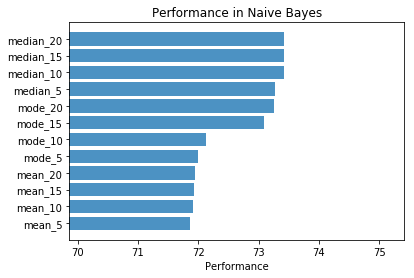

In [260]:
objects = df_data_naive_b.index.values
y_pos = np.arange(len(objects))
performance = df_data_naive_b.iloc[:,0].sort_values(ascending=True)

print(str(y_pos))
print(performance.min())
plt.barh(y_pos, performance, align='center', alpha=0.8,left=0)
# plt.xticks(np.arange(70, 100, step=2))
plt.xlim(performance.min()-2, performance.max()+2)
plt.yticks(y_pos, objects)
plt.xlabel('Performance')
plt.title('Performance in Naive Bayes')

plt.show()

# Support Vector Machines

In [263]:
data_svm = get_all_data()

In [ ]:
from sklearn.svm import SVC
models_svc = {}
for key, value in data_svm.items():
    model_svc = SVC()
    model_svc.fit(
        value['X_train'],
        value['y_train']
    )
    prediction_svc = model_svc.predict(value['X_test'])
    models_svc[key] = [model_svc,prediction_svc]

/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/marianbauersachs/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/marianbauersach

In [ ]:
index_data_svc = []
column_data_svc = []
for key, value in models_svc.items():
    index_data_svc.append(key)
    column_data_svc.append(100*(1-(data_svm[key]['y_test'] != value[1]).sum()/data_svm[key]['y_test'].shape[0]))

In [ ]:
objects = data_svm.index.values
y_pos = np.arange(len(objects))
performance = data_svm.iloc[:,0].sort_values(ascending=True)

print(str(y_pos))
print(performance.min())
plt.barh(y_pos, performance, align='center', alpha=0.8,left=0)
# plt.xticks(np.arange(70, 100, step=2))
plt.xlim(performance.min()-2, performance.max()+2)
plt.yticks(y_pos, objects)
plt.xlabel('Performance')
plt.title('Performance in Naive Bayes')

plt.show()

# Decision Tree Classifier

In [27]:
data_dtc = get_all_data()

In [24]:
from sklearn.tree import DecisionTreeClassifier
models_dtc = {}
for key, value in data_dtc.items():
    model_dtree = DecisionTreeClassifier()
    model_dtree.fit(
        value['X_train'],
        value['y_train']
    )
    prediction_dtc = model_dtree.predict(value['X_test'])
    models_dtc[key] = [model_dtree,prediction_dtc]

In [25]:
index_data_dtc = []
column_data_dtc = []
for key, value in models_dtc.items():
    index_data_dtc.append(key)
    column_data_dtc.append(100*(1-(data_dtc[key]['y_test'] != value[1]).sum()/data_dtc[key]['y_test'].shape[0]))

In [29]:
df_data_dtc = pd.DataFrame(index=index_data_dtc, data=column_data_dtc)

In [34]:
objects = df_data_dtc.index.values
y_pos = np.arange(len(objects))
performance = df_data_dtc.iloc[:,0].sort_values(ascending=True)

print(str(y_pos))
print(performance.min())
plt.barh(y_pos, performance, align='center', alpha=0.8,left=0)
# plt.xticks(np.arange(70, 100, step=2))
plt.xlim(performance.min()-2, performance.max()+2)
plt.yticks(y_pos, objects)
plt.xlabel('Performance')
plt.title('Performance in Naive Bayes')

plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11]
71.68279044998668


NameError: name 'plt' is not defined

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
model_dtc_2 =  DecisionTreeClassifier()
model_dtc_2.fit(
    data_dtc['median_20']['X_train'],
    data_dtc['median_20']['y_train']
)
prediction_dtc_2 = model_dtc_2.predict(data_dtc['median_20']['X_test'])

In [ ]:
prediction_dtc_2 = model_dtc_2.predict(data_rfm['median_20']['X_test'])

In [22]:
performance_dtc_2 = 100*(1-(data_dtc['median_20']['y_test'] != prediction_dtc_2[1]).sum()/data_dtc['median_20']['y_test'].shape[0])
performance_dtc_2

68.06159581077482

# Random Forest model

In [8]:
data_rfm = get_all_data()

In [10]:
from sklearn.ensemble import RandomForestClassifier
models_rfm = {}
for key, value in data_rfm.items():
    model_rfm =  RandomForestClassifier(n_estimators=600)
    model_rfm.fit(
        value['X_train'],
        value['y_train']
    )
    prediction_rfm = model_rfm.predict(value['X_test'])
    models_rfm[key] = [model_rfm,prediction_rfm]

KeyboardInterrupt: 

In [ ]:
index_data_rfm = []
column_data_rfm = []
for key, value in models_rfm.items():
    index_data_rfm.append(key)
    column_data_rfm.append(100*(1-(data_rfm[key]['y_test'] != value[1]).sum()/data_rfm[key]['y_test'].shape[0]))

In [ ]:
objects = data_rfm.index.values
y_pos = np.arange(len(objects))
performance = data_rfm.iloc[:,0].sort_values(ascending=True)

print(str(y_pos))
print(performance.min())
plt.barh(y_pos, performance, align='center', alpha=0.8,left=0)
# plt.xticks(np.arange(70, 100, step=2))
plt.xlim(performance.min()-2, performance.max()+2)
plt.yticks(y_pos, objects)
plt.xlabel('Performance')
plt.title('Performance in Naive Bayes')

plt.show()

In [15]:
model_rfm_2 =  RandomForestClassifier(n_estimators=600)
model_rfm_2.fit(
    data_rfm['median_20']['X_train'],
    data_rfm['median_20']['y_train']
)
prediction_rfm_2 = model_rfm_2.predict(value['X_test'])

ValueError: Number of features of the model must match the input. Model n_features is 20 and input n_features is 15 

In [16]:
prediction_rfm_2 = model_rfm_2.predict(data_rfm['median_20']['X_test'])

In [17]:
performance_rfm_2 = 100*(1-(data_rfm['median_20']['y_test'] != prediction_rfm_2[1]).sum()/data_rfm['median_20']['y_test'].shape[0])
performance_rfm_2

68.06159581077482